In [1]:
#Instalacion de las librerias generadas para el respectivo analisis 
!pip install pandas openpyxl matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#importacion de las librerias necesarias 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Definir la ruta base a la carpeta 'data/raw'
base_path = '../data/raw/' # # Ajusta según tu ubicación relativa si es necesario

# Definir los archivos de ventas de interés
# *** CORRECCIÓN AQUÍ: Se cambió '4q4.xlsx' a '4de4.xlsx' para que coincida con tu archivo real ***
ventas_2024_file = os.path.join(base_path, 'ventas_dcto_2024_4de4.xlsx')
ventas_2025_file = os.path.join(base_path, 'ventas_dcto_items_2025.xlsx') # <-- ¡Aquí se define!
clientes_file = os.path.join(base_path, 'clientes.xlsx')

# Definir el horizonte temporal
fecha_inicio_analisis = pd.to_datetime('2024-01-01')
fecha_fin_analisis = pd.to_datetime('2025-06-11') # Ajusta si tienes datos más recientes

In [6]:
# Definir la ruta base a la carpeta 'data/raw'
base_path = '../data/raw/' # O ajusta según tu ubicación relativa

# Definir los archivos de ventas de interés
# ¡CORRECCIÓN AQUÍ! Ajusta el nombre del archivo de 2024
ventas_2024_file = os.path.join(base_path, 'ventas_dcto_2024_4de4.xlsx') # <--- ¡CAMBIO AQUÍ!
ventas_2025_file = os.path.join(base_path, 'ventas_dcto_items_2025.xlsx') # Este parece estar bien
clientes_file = os.path.join(base_path, 'clientes.xlsx')

# Definir el horizonte temporal
fecha_inicio_analisis = pd.to_datetime('2024-01-01')
fecha_fin_analisis = pd.to_datetime('2025-06-11') # Ajusta si tienes datos más recientes

In [7]:
# --- PASO DE INSPECCIÓN: VERIFICAR NOMBRES DE COLUMNAS ---
# Cargar solo la primera fila de cada archivo para ver los encabezados
try:
    df_ventas_2024_sample = pd.read_excel(ventas_2024_file, nrows=0) # nrows=0 carga solo los encabezados
    print(f"Columnas de {os.path.basename(ventas_2024_file)}:")
    for col in df_ventas_2024_sample.columns:
        print(f"- {col}")
    print("-" * 30)

    df_ventas_2025_sample = pd.read_excel(ventas_2025_file, nrows=0)
    print(f"Columnas de {os.path.basename(ventas_2025_file)}:")
    for col in df_ventas_2025_sample.columns:
        print(f"- {col}")
    print("-" * 30)

    df_clientes_sample = pd.read_excel(clientes_file, nrows=0)
    print(f"Columnas de {os.path.basename(clientes_file)}:")
    for col in df_clientes_sample.columns:
        print(f"- {col}")
    print("-" * 30)

except FileNotFoundError as e:
    print(f"Error: No se encontró uno de los archivos. Revisa las rutas. Detalles: {e}")
except Exception as e:
    print(f"Ocurrió un error al leer los archivos: {e}")

print("\n--- ¡AHORA, USA ESTOS NOMBRES EXACTOS PARA DEFINIR TUS VARIABLES DE COLUMNA! ---")

Columnas de ventas_dcto_2024_4de4.xlsx:
- cod_cliente
- cliente
- documento
- defecha
- vr_gravado
- vr_nogravado
- subtotal
- costo
- utilidadps
- utilidadpc
- iva
- total
- tipodocumento
- bodega
- vendedor
- distrito
------------------------------
Columnas de ventas_dcto_items_2025.xlsx:
- cod_cliente
- cliente
- documento
- defecha
- cod_articulo_servicio
- nombre_articulo_servicio
- cantidad
- porc_iva
- vrgravado
- vrnogravado
- descuento
- subtotal
- costo
- utilidadps
- utilidadpc
- tipodocumento
- cuenta
- nomcuenta
- icolicoresunitario
- bodega
- vendedor
- distrito
------------------------------
Columnas de clientes.xlsx:
- codigo
- razon social
- direccion
- nombre ciudad
- cod ciudad
- cupo
- plazo
- telefonos
- contactos
- telefonos.1
- telefonos.2
- email
- vendedor
- nit
- dv
- distrito
- pais
------------------------------

--- ¡AHORA, USA ESTOS NOMBRES EXACTOS PARA DEFINIR TUS VARIABLES DE COLUMNA! ---


In [8]:
# --- Normalizar nombres de columnas (AJUSTA ESTO SEGÚN TUS NOMBRES REALES DE COLUMNA) ---
# Es CRÍTICO que los nombres de las columnas aquí coincidan EXACTAMENTE con los de tus Excels.

# Columnas comunes en df_ventas (ambos 2024 y 2025)
id_cliente_col = 'cod_cliente'       # Está en ventas_dcto_2024_4de4.xlsx y ventas_dcto_items_2025.xlsx, y 'codigo' en clientes.xlsx (¡ojo con el merge!)
fecha_venta_col = 'defecha'          # Está en ventas_dcto_2024_4de4.xlsx y ventas_dcto_items_2025.xlsx
cantidad_item_col = 'cantidad'       # Está en ventas_dcto_items_2025.xlsx (¡ojo! no está en el primer archivo de 2024, esto puede ser un problema si necesitas cantidad de allí)
# Para el volumen monetario, podemos usar 'total' o 'subtotal' de ventas_dcto_2024_4de4.xlsx
# y para ventas_dcto_items_2025.xlsx, necesitaríamos 'vrrgravado' o 'vrnogravado' + 'descuento' o calcular desde 'cantidad' y un precio unitario (que no veo uno claro).
# Vamos a usar 'total' de 2024 y 'vrgravado' de 2025 por ahora, y si no funciona bien, lo ajustamos.

# Es fundamental que definamos cómo calcular el valor monetario de un ITEM
# En 'ventas_dcto_2024_4de4.xlsx', tienes 'total' que parece ser el valor de la venta a nivel de documento.
# En 'ventas_dcto_items_2025.xlsx', tienes 'cantidad', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal', 'costo'.
# Para volumen monetario, necesitamos el valor de cada ITEM. 'vrgravado' o 'vrnogravado' o 'subtotal' por ítem son candidatos.
# Asumiremos que para 2025, 'vrgravado' es el valor relevante por ítem antes de descuento, o 'subtotal' si es el valor neto del ítem.
# La columna 'total' de 2024 es el valor total del documento, no del ítem. Esto es una diferencia importante.

# Ajustaremos la lógica de cálculo del volumen monetario para cada DF de ventas si sus columnas son diferentes.
# Por ahora, vamos a definir 'valor_item_col' como 'vrgravado' para 2025, que es lo más parecido a un precio unitario o valor del item gravado.
# Para 2024, si no hay 'cantidad' o 'precio_unitario' por ítem, tendremos que sumar 'total' por cliente (lo que sumaría los totales de las facturas).

# ¡IMPORTANTE! Revisa tus archivos Excel de nuevo para confirmar la columna que representa el valor monetario POR ÍTEM.
# Si 'vrgravado' es el valor unitario (precio), entonces:
# valor_item_col = 'vrgravado' # En ventas_dcto_items_2025.xlsx

# Para la frecuencia de compra, necesitamos un identificador único por transacción/documento.
id_transaccion_col = 'documento' # 'documento' parece ser el ID único de la transacción en ambos archivos de ventas.

# --- Fin de ajuste de nombres de columnas ---

Datos de Ventas 2024 filtrados (primeras 5 filas):
        cod_cliente                                      cliente  \
0  CL  100000000398                       CENCOSUD COLOMBIA S.A.   
1  CL  100000000398                       CENCOSUD COLOMBIA S.A.   
2  CL  100000000398                       CENCOSUD COLOMBIA S.A.   
3  CL  100000000606  SANTA BARBARA INVESTMENTS SUCURSAL COLOMBIA   
4  CL  100000001876                               MONFERRINA SAS   

       documento    defecha  vr_gravado  vr_nogravado    subtotal       costo  \
0    1PCH  37299 2024-10-01  13920414.0       1191840  15112254.0  7808058.49   
1    1PCH  37300 2024-10-01   2163000.0             0   2163000.0  1027464.60   
2    1PCH  37301 2024-10-01    712452.0             0    712452.0   329509.44   
3    1PCH  37302 2024-10-01   1216250.0       1496900   2713150.0  1349405.05   
4    1PCH  37303 2024-10-01    711510.0             0    711510.0   371145.73   

   utilidadps  utilidadpc      iva       total tipodo

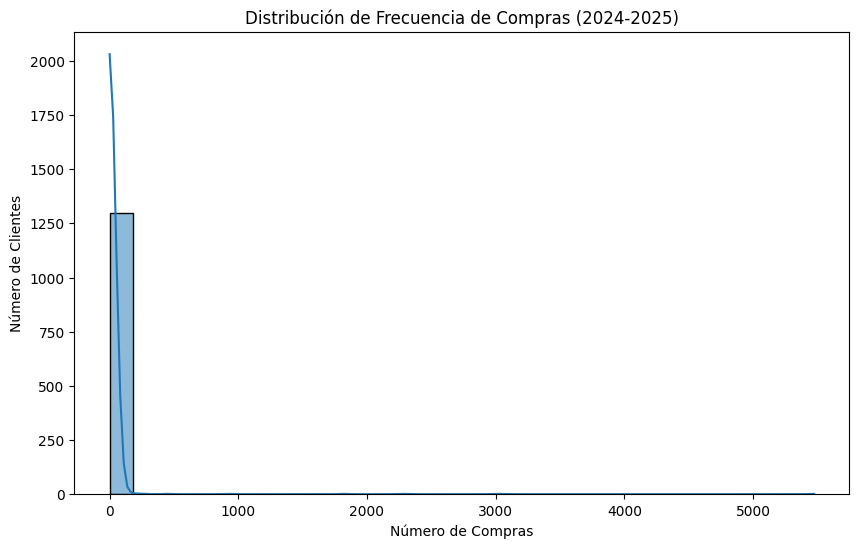

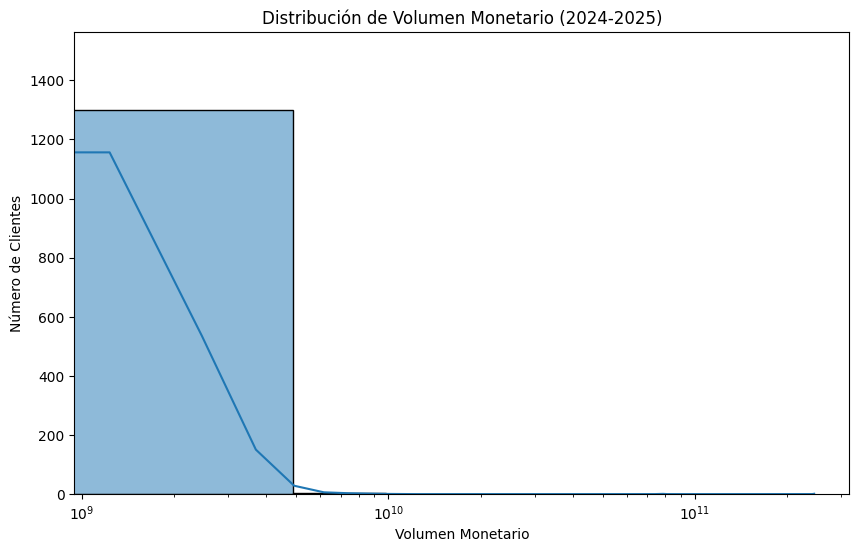

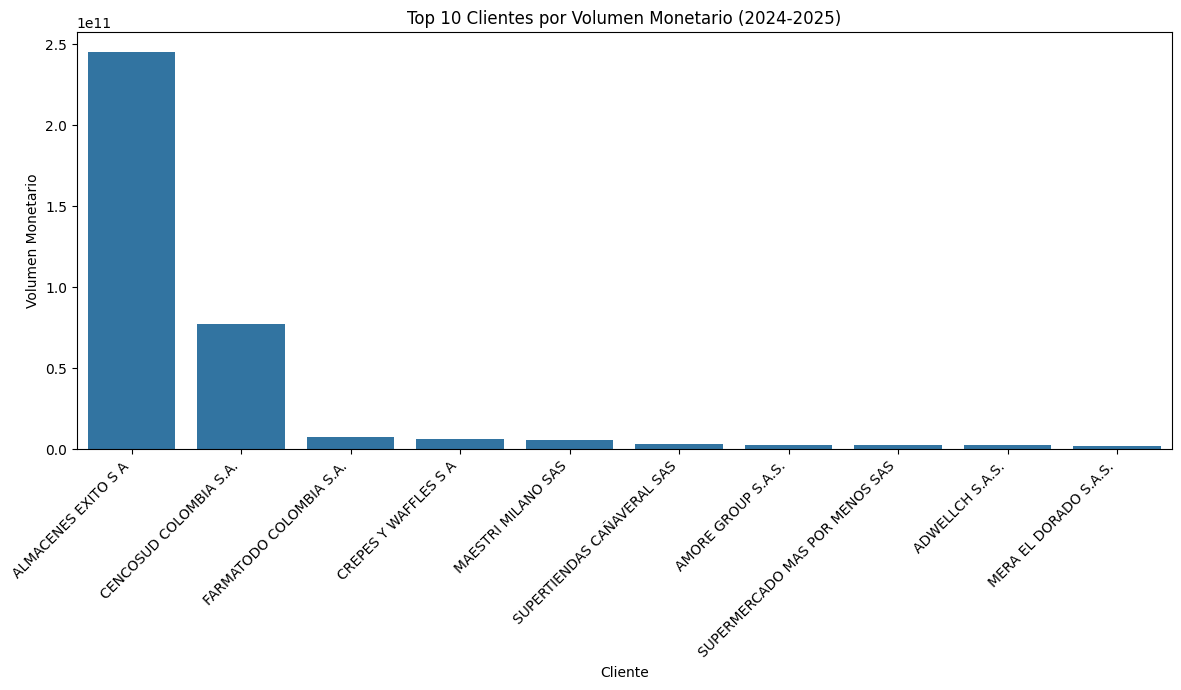

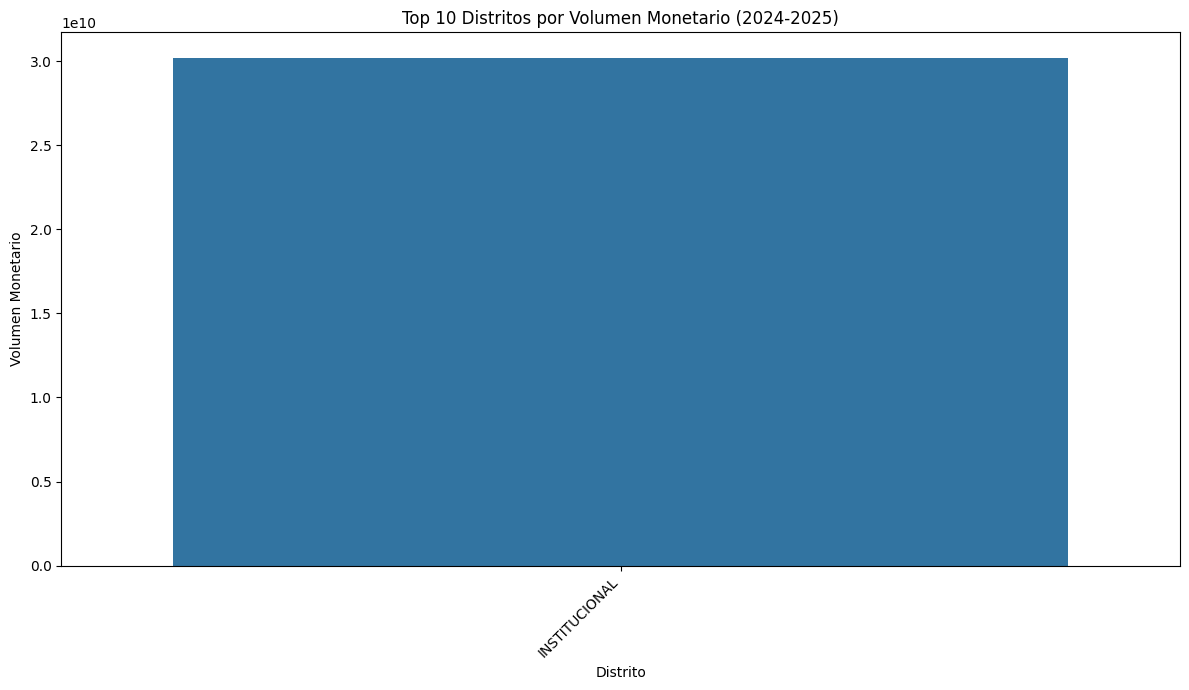

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Definir Rutas de Archivos y Horizonte Temporal ---
# Asegúrate de que esta ruta sea correcta desde donde ejecutas el notebook
base_path = '../data/raw/' # Asumo que el notebook está en 'notebooks/' y 'data/' está al mismo nivel

# Definir los archivos de ventas y clientes de interés
# *** CORRECCIÓN CRÍTICA AQUÍ: Cambiado '4q4.xlsx' a '4de4.xlsx' para que coincida con tu archivo real ***
ventas_2024_file = os.path.join(base_path, 'ventas_dcto_2024_4de4.xlsx')
ventas_2025_file = os.path.join(base_path, 'ventas_dcto_items_2025.xlsx')
clientes_file = os.path.join(base_path, 'clientes.xlsx')

# Definir el horizonte temporal (desde 1 de enero de 2024 hasta la fecha actual)
fecha_inicio_analisis = pd.to_datetime('2024-01-01')
fecha_fin_analisis = pd.to_datetime('2025-06-11') # Ajusta si tienes datos más recientes

# --- 2. Cargar y Preprocesar Datos ---

# Cargar datos de ventas
try:
    df_ventas_2024 = pd.read_excel(ventas_2024_file)
    df_ventas_2025 = pd.read_excel(ventas_2025_file)
    df_clientes = pd.read_excel(clientes_file)
except FileNotFoundError as e:
    print(f"ERROR: No se encontró uno de los archivos. Revisa las rutas en 'base_path' y los nombres de los archivos. Detalle: {e}")
    exit() # Termina la ejecución si un archivo no se encuentra

# --- 3. Normalizar Nombres de Columnas (¡CRÍTICO!) ---
# Estos nombres deben COINCIDIR EXACTAMENTE con los encabezados en Tus Excels
id_cliente_col = 'cod_cliente'    # Columna de ID de cliente en ventas
fecha_venta_col = 'defecha'      # Columna de fecha de venta/transacción
id_transaccion_col = 'documento' # Columna de ID único de la transacción/documento

# NOTA sobre valores monetarios y cantidades:
# df_ventas_2024 tiene 'total' (total del documento)
# df_ventas_2024_items tiene 'cantidad' y 'vrgravado' (ambos a nivel de ítem)
# df_clientes tiene 'codigo' como ID de cliente y 'razon social' como nombre de cliente.

# Renombrar columnas en df_clientes para que 'codigo' sea 'cod_cliente' y 'razon social' sea 'nombre_cliente_display' para unificar
df_clientes.rename(columns={'codigo': id_cliente_col, 'razon social': 'nombre_cliente_display'}, inplace=True)

# Convertir la columna de fecha a tipo datetime para ambos DataFrames de ventas
df_ventas_2024[fecha_venta_col] = pd.to_datetime(df_ventas_2024[fecha_venta_col])
df_ventas_2025[fecha_venta_col] = pd.to_datetime(df_ventas_2025[fecha_venta_col])

# Filtrar por el horizonte temporal definido (2024-2025)
df_ventas_2024_filtrado = df_ventas_2024[
    (df_ventas_2024[fecha_venta_col] >= fecha_inicio_analisis) &
    (df_ventas_2024[fecha_venta_col] <= fecha_fin_analisis)
].copy()

df_ventas_2025_filtrado = df_ventas_2025[
    (df_ventas_2025[fecha_venta_col] >= fecha_inicio_analisis) &
    (df_ventas_2025[fecha_venta_col] <= fecha_fin_analisis)
].copy()

print("Datos de Ventas 2024 filtrados (primeras 5 filas):")
print(df_ventas_2024_filtrado.head())
print("\nDatos de Ventas 2025 filtrados (primeras 5 filas):")
print(df_ventas_2025_filtrado.head())

# --- 4. Calcular Frecuencia y Volumen para CADA AÑO POR SEPARADO ---
# Esto es necesario por las diferencias en la estructura de los archivos (documento vs. ítem)

# 4.1. Métricas para 2024 (nivel de DOCUMENTO)
# La frecuencia es el número de documentos únicos
frecuencia_2024 = df_ventas_2024_filtrado.groupby(id_cliente_col)[id_transaccion_col].nunique().reset_index(name='frecuencia_compras_2024')
# El volumen monetario es la suma del total de cada documento
volumen_monetario_2024 = df_ventas_2024_filtrado.groupby(id_cliente_col)['total'].sum().reset_index(name='volumen_monetario_2024')

# Volumen de unidades para 2024 (si aplica y tienes datos)
# *** CORRECCIÓN AQUÍ: Se usa el VALOR de id_cliente_col como la clave del diccionario ***
# Asumo 0 para 2024 si no hay datos de cantidad por item en ventas_2024_filtrado
volumen_unidades_2024 = pd.DataFrame({id_cliente_col: df_ventas_2024_filtrado[id_cliente_col].unique(), 'volumen_unidades_2024': 0})

df_metrics_2024 = pd.merge(frecuencia_2024, volumen_monetario_2024, on=id_cliente_col, how='left')
df_metrics_2024 = pd.merge(df_metrics_2024, volumen_unidades_2024, on=id_cliente_col, how='left')


# 4.2. Métricas para 2025 (nivel de ÍTEM)
# Primero, calculamos el valor total por ítem (cantidad * vrgravado)
df_ventas_2025_filtrado['valor_total_item'] = df_ventas_2025_filtrado['cantidad'] * df_ventas_2025_filtrado['vrgravado']

# La frecuencia es el número de transacciones únicas (documentos)
frecuencia_2025 = df_ventas_2025_filtrado.groupby(id_cliente_col)[id_transaccion_col].nunique().reset_index(name='frecuencia_compras_2025')
# El volumen monetario es la suma del valor total del ítem
volumen_monetario_2025 = df_ventas_2025_filtrado.groupby(id_cliente_col)['valor_total_item'].sum().reset_index(name='volumen_monetario_2025')
# El volumen de unidades es la suma de la cantidad de ítems
volumen_unidades_2025 = df_ventas_2025_filtrado.groupby(id_cliente_col)['cantidad'].sum().reset_index(name='volumen_unidades_2025') # Suma la cantidad de ítems
df_metrics_2025 = pd.merge(frecuencia_2025, volumen_monetario_2025, on=id_cliente_col, how='left')
df_metrics_2025 = pd.merge(volumen_unidades_2025, df_metrics_2025, on=id_cliente_col, how='left') # Corregido orden del merge por si acaso

# --- 5. Consolidar Métricas de 2024 y 2025 ---
# asumimos outer merge para incluir todos los clientes de ambos años
df_consolidado = pd.merge(df_metrics_2024, df_metrics_2025, on=id_cliente_col, how='outer')

# Sumar las frecuencias y volúmenes (rellenando NaNs con 0 para clientes que solo compraron en un año)
df_consolidado['frecuencia_compras_2024_2025'] = df_consolidado['frecuencia_compras_2024'].fillna(0) + df_consolidado['frecuencia_compras_2025'].fillna(0)
df_consolidado['volumen_monetario_2024_2025'] = df_consolidado['volumen_monetario_2024'].fillna(0) + df_consolidado['volumen_monetario_2025'].fillna(0)
df_consolidado['volumen_unidades_2024_2025'] = df_consolidado['volumen_unidades_2024'].fillna(0) + df_consolidado['volumen_unidades_2025'].fillna(0) # Asumimos 0 para si no hay datos de cantidad por item.

# Seleccionar solo las columnas consolidadas y el ID de cliente
# **CORRECCIÓN ANTERIOR**: Usamos .reset_index() para asegurar que 'id_cliente_col' sea una columna y no el índice.
df_resultado_final = df_consolidado.reset_index()[[id_cliente_col, 'frecuencia_compras_2024_2025', 'volumen_monetario_2024_2025', 'volumen_unidades_2024_2025']].copy()

# Unir la información de clientes (nombre del cliente y distrito), usando la columna 'id_cliente_col'
# *** CORRECCIÓN FINAL: Se usa el VALOR de id_cliente_col para la selección y el parámetro 'on' ***
df_resultado_final = pd.merge(df_resultado_final, df_clientes[[id_cliente_col, 'nombre_cliente_display', 'distrito']], on=id_cliente_col, how='left')

# Ordenar por volumen monetario descendente para ver los top clientes
df_resultado_final_ordenado = df_resultado_final.sort_values(by='volumen_monetario_2024_2025', ascending=False)

print("\n--- RESULTADOS FINALES ---")
print("Primeras 5 filas del DataFrame final con métricas de 2024-2025:")
print(df_resultado_final_ordenado.head())
print("\nInformación del DataFrame final:")
df_resultado_final_ordenado.info()

# --- 6. Exportar Resultados a Excel ---
output_file_name = "frecuencia_volumen_clientes_2024_2025_para_validacion.xlsx"
output_path = '../outputs/' # Asumiendo que tienes una carpeta 'outputs' al mismo nivel que 'notebooks'
os.makedirs(output_path, exist_ok=True) # Asegura que la carpeta 'outputs' exista

df_resultado_final_ordenado.to_excel(os.path.join(output_path, output_file_name), index=False)
print(f"\nDatos exportados exitosamente a: {os.path.join(output_path, output_file_name)}")


# --- 7. (Opcional) Visualizaciones Rápidas ---
# Te ayudarán a entender la distribución de tus datos

# Distribución de Frecuencia de Compras
plt.figure(figsize=(10, 6))
sns.histplot(df_resultado_final_ordenado['frecuencia_compras_2024_2025'], bins=30, kde=True)
plt.title('Distribución de Frecuencia de Compras (2024-2025)')
plt.xlabel('Número de Compras')
plt.ylabel('Número de Clientes')
plt.show()

# Distribución de Volumen Monetario (usando escala logarítmica para clientes con valores muy altos)
plt.figure(figsize=(10, 6))
sns.histplot(df_resultado_final_ordenado['volumen_monetario_2024_2025'], bins=50, kde=True)
plt.title('Distribución de Volumen Monetario (2024-2025)')
plt.xlabel('Volumen Monetario')
plt.ylabel('Número de Clientes')
plt.xscale('log') # Usa escala logarítmica para manejar la dispersión
plt.show()

# Top 10 clientes por volumen monetario
plt.figure(figsize=(12, 7))
sns.barplot(x='nombre_cliente_display', y='volumen_monetario_2024_2025', data=df_resultado_final_ordenado.head(10))
plt.title('Top 10 Clientes por Volumen Monetario (2024-2025)')
plt.xlabel('Cliente')
plt.ylabel('Volumen Monetario')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Opcional: Top 10 distritos por volumen monetario
# Primero, asegurémonos de que 'distrito' no tenga NaNs si no quieres que aparezcan como una categoría separada en el gráfico
# df_resultado_final_ordenado['distrito'] = df_resultado_final_ordenado['distrito'].fillna('Desconocido')

distrito_volumen = df_resultado_final_ordenado.groupby('distrito')['volumen_monetario_2024_2025'].sum().reset_index()
distrito_volumen = distrito_volumen.sort_values(by='volumen_monetario_2024_2025', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='distrito', y='volumen_monetario_2024_2025', data=distrito_volumen.head(10))
plt.title('Top 10 Distritos por Volumen Monetario (2024-2025)')
plt.xlabel('Distrito')
plt.ylabel('Volumen Monetario')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import os

# Suponiendo que tus DataFrames df_ventas_2024, df_ventas_2025 y df_clientes ya han sido cargados
# Si estás poniendo esto al principio del script, asegúrate de que los DataFrames existan antes de llamar a esto.

print("--- Verificación de Columnas de df_ventas_2024 ---")
print(f"Columnas de df_ventas_2024 ({os.path.basename(ventas_2024_file)}):")
for col in df_ventas_2024.columns:
    print(f"- {col}")
print("-" * 30)
print("Primeras 5 filas de df_ventas_2024:")
print(df_ventas_2024.head())
print("-" * 30)
print("Información de df_ventas_2024:")
df_ventas_2024.info()
print("=" * 50)

print("\n--- Verificación de Columnas de df_ventas_2025 ---")
print(f"Columnas de df_ventas_2025 ({os.path.basename(ventas_2025_file)}):")
for col in df_ventas_2025.columns:
    print(f"- {col}")
print("-" * 30)
print("Primeras 5 filas de df_ventas_2025:")
print(df_ventas_2025.head())
print("-" * 30)
print("Información de df_ventas_2025:")
df_ventas_2025.info()
print("=" * 50)


print("\n--- Verificación de Columnas de df_clientes ---")
print(f"Columnas de df_clientes ({os.path.basename(clientes_file)}):")
for col in df_clientes.columns:
    print(f"- {col}")
print("-" * 30)
print("Primeras 5 filas de df_clientes:")
print(df_clientes.head())
print("-" * 30)
print("Información de df_clientes:")
df_clientes.info()
print("=" * 50)

# Si quieres ver las columnas de los DataFrames filtrados (después de aplicar los filtros de fecha)
# Esto sería más útil después de la sección de filtrado.
# print("\n--- Verificación de Columnas de df_ventas_2024_filtrado ---")
# print(df_ventas_2024_filtrado.columns.tolist())
# print("\n--- Verificación de Columnas de df_ventas_2025_filtrado ---")
# print(df_ventas_2025_filtrado.columns.tolist())

--- Verificación de Columnas de df_ventas_2024 ---
Columnas de df_ventas_2024 (ventas_dcto_2024_4de4.xlsx):
- cod_cliente
- cliente
- documento
- defecha
- vr_gravado
- vr_nogravado
- subtotal
- costo
- utilidadps
- utilidadpc
- iva
- total
- tipodocumento
- bodega
- vendedor
- distrito
------------------------------
Primeras 5 filas de df_ventas_2024:
        cod_cliente                                      cliente  \
0  CL  100000000398                       CENCOSUD COLOMBIA S.A.   
1  CL  100000000398                       CENCOSUD COLOMBIA S.A.   
2  CL  100000000398                       CENCOSUD COLOMBIA S.A.   
3  CL  100000000606  SANTA BARBARA INVESTMENTS SUCURSAL COLOMBIA   
4  CL  100000001876                               MONFERRINA SAS   

       documento    defecha  vr_gravado  vr_nogravado    subtotal       costo  \
0    1PCH  37299 2024-10-01  13920414.0       1191840  15112254.0  7808058.49   
1    1PCH  37300 2024-10-01   2163000.0             0   2163000.0  1027464

In [14]:
# Para df_ventas_2024
print(df_ventas_2024.columns)


Index(['cod_cliente', 'cliente', 'documento', 'defecha', 'vr_gravado',
       'vr_nogravado', 'subtotal', 'costo', 'utilidadps', 'utilidadpc', 'iva',
       'total', 'tipodocumento', 'bodega', 'vendedor', 'distrito'],
      dtype='object')


In [15]:
# Para df_ventas_2025
print(df_ventas_2025.columns)

Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'costo', 'utilidadps', 'utilidadpc', 'tipodocumento', 'cuenta',
       'nomcuenta', 'icolicoresunitario', 'bodega', 'vendedor', 'distrito'],
      dtype='object')


In [16]:
# Para df_clientes
print(df_clientes.columns)

Index(['cod_cliente', 'nombre_cliente_display', 'direccion', 'nombre ciudad',
       'cod ciudad', 'cupo', 'plazo', 'telefonos', 'contactos', 'telefonos.1',
       'telefonos.2', 'email', 'vendedor', 'nit', 'dv', 'distrito', 'pais'],
      dtype='object')
